In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lifelines as lflns
sns.set_style('whitegrid')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

In [3]:
# Load training data and impute categorical variables.

hct_df = pd.read_csv("../data/train_set.csv")

# Replace text value that corresponding so missing data with NaN
hct_df = hct_df.replace(to_replace=["Missing Disease Status", "Missing disease status"], value=np.nan)

# drop columns that aren't appropriate for prediction
hct_df = hct_df.drop(columns=['ID', 'year_hct'])
hct_df.shape

(23040, 58)

In [3]:
features = hct_df.drop(['efs', 'efs_time'], axis=1)
targets = hct_df[['efs', 'efs_time']]
cat_cols = list(features.select_dtypes(include='O').columns)
to_scale = ['donor_age', 'age_at_hct', 'karnofsky_score']
features.shape

(23040, 56)

In [38]:
pipeline = Pipeline(
    [
        (
            "encode and scale",
            ColumnTransformer(
                [
                    ('one_hot', OneHotEncoder(drop='first', min_frequency=0.001, handle_unknown='ignore'), cat_cols),
                    ('scale', StandardScaler(), to_scale)
                ],
                sparse_threshold=0,
                remainder='passthrough',
                verbose_feature_names_out=False,
                force_int_remainder_cols=False
            )
        ),
        (
        "impute",
         KNNImputer()
        )
    ],
    verbose=True
)

In [39]:
pipeline.fit(features)

[Pipeline] .. (step 1 of 2) Processing encode and scale, total=   0.6s
[Pipeline] ............ (step 2 of 2) Processing impute, total=   0.0s


Pipeline(steps=[('encode and scale',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough', sparse_threshold=0,
                                   transformers=[('one_hot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                min_frequency=0.001),
                                                  ['dri_score', 'psych_disturb',
                                                   'cyto_score', 'diabetes',
                                                   'tbi_status', 'arrhythmia',
                                                   'graft_type', 'vent_hist',
                                                   'renal_issue', 'pulm_sev...
                                                   'cyto_score_detail',
                                                   'conditioning_intensity',
                                                   'ethnicity', 'obesity',
                                                   'mrd_hct', 'in_vivo_tcd',
                                                   'tce_match',
                                                   'hepatic_severe',
                                                   'prior_tumor',
                                                   'peptic_ulcer', 'gvhd_proph',
                                                   'rheum_issue', 'sex_match',
                                                   'race_group', 'hepatic_mild', ...]),
                                                 ('scale', StandardScaler(),
                                                  ['donor_age', 'age_at_hct',
                                                   'karnofsky_score'])],
                                   verbose_feature_names_out=False)),
                ('impute', KNNImputer())],
         verbose=True)

In [40]:
features_processed = pd.DataFrame(pipeline.transform(features), columns=pipeline.get_feature_names_out())

In [41]:
features.shape

(23040, 56)

In [42]:
features_processed.shape

(23040, 175)

In [4]:
hct_df = hct_df.sample(1000)
hct_df

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
13944,High,No,NaN,No,2.0,7.0,No TBI,No,6.0,Peripheral blood,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,1.0,4.388
19177,Intermediate,No,Favorable,No,NaN,NaN,No TBI,No,NaN,Peripheral blood,...,NaN,Related,"N/A, Mel not given",NaN,No,NaN,No,NaN,1.0,10.942
20905,High,No,Poor,No,1.0,4.0,TBI + Cy +- Other,No,3.0,Peripheral blood,...,Permissive mismatched,Related,MEL,4.0,No,1.0,No,6.0,1.0,4.494
9260,Intermediate,No,Intermediate,No,2.0,7.0,No TBI,No,5.0,Bone marrow,...,Permissive mismatched,Unrelated,"N/A, Mel not given",7.0,No,2.0,No,9.0,0.0,25.595
4269,N/A - pediatric,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,1.0,5.048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5245,N/A - pediatric,Yes,NaN,No,2.0,7.0,No TBI,No,6.0,Bone marrow,...,Permissive mismatched,Unrelated,MEL,8.0,No,1.0,Yes,10.0,0.0,25.625
14082,High,No,Intermediate,No,2.0,7.0,No TBI,Yes,6.0,Peripheral blood,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,0.0,72.520
7162,Intermediate,No,Normal,Yes,1.0,4.0,TBI + Cy +- Other,No,3.0,Peripheral blood,...,NaN,Related,"N/A, Mel not given",4.0,No,1.0,No,5.0,1.0,8.037
3482,High - TED AML case <missing cytogenetics,No,Intermediate,No,1.0,5.0,No TBI,No,3.0,Peripheral blood,...,Permissive mismatched,Related,"N/A, Mel not given",4.0,No,1.0,No,6.0,0.0,75.151


In [7]:
feat_names = hct_df.columns[:-2]
target_names = ['efs', 'efs_time']
cat_cols = list(hct_df.select_dtypes(include='O').columns)
to_scale = ['donor_age', 'age_at_hct', 'karnofsky_score']
from lifelines import CoxPHFitter

n_splits=5
kfold = KFold(n_splits=n_splits, shuffle=True)
scores = np.zeros(n_splits)

for num, (train_idx, test_idx) in enumerate(kfold.split(hct_df)):
    
    train = hct_df.iloc[train_idx]
    test = hct_df.iloc[test_idx]

    pipeline = Pipeline(
        [
            (
                "encode and scale",
                ColumnTransformer(
                    [
                        ('one_hot', OneHotEncoder(drop='first', handle_unknown='warn'), cat_cols),
                        ('scale', StandardScaler(), to_scale)
                    ],
                    sparse_threshold=0,
                    remainder='passthrough',
                    verbose_feature_names_out=False,
                    force_int_remainder_cols=False
                )
            ),
            (
                "impute",
                KNNImputer()
            ),
        ],
        verbose=True
    )


    X_train_proc = pd.DataFrame(pipeline.fit_transform(train[feat_names]), columns=pipeline.get_feature_names_out(), index=train_idx)
    y_train_proc = train[target_names]
"""
#X_test = pd.DataFrame(pipeline.transform(X_test), columns=pipeline.get_feature_names_out())

    #cph = CoxPHFitter()
    #cph.fit(train, duration_col='efs_time', event_col='efs')
    #scores[num] = cph.concordance_index_""
"""


[Pipeline] .. (step 1 of 2) Processing encode and scale, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing impute, total=   0.1s
[Pipeline] .. (step 1 of 2) Processing encode and scale, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing impute, total=   0.1s
[Pipeline] .. (step 1 of 2) Processing encode and scale, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing impute, total=   0.1s
[Pipeline] .. (step 1 of 2) Processing encode and scale, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing impute, total=   0.1s
[Pipeline] .. (step 1 of 2) Processing encode and scale, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing impute, total=   0.1s


'\n#X_test = pd.DataFrame(pipeline.transform(X_test), columns=pipeline.get_feature_names_out())\n\n    #cph = CoxPHFitter()\n    #cph.fit(train, duration_col=\'efs_time\', event_col=\'efs\')\n    #scores[num] = cph.concordance_index_""\n'

In [48]:
train

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
19038,Intermediate,No,Poor,Yes,2.0,8.0,"TBI +- Other, <=cGy",No,6.0,Peripheral blood,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,1.0,4.048
13964,High,No,Poor,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,1.0,4.622
10964,Intermediate,No,Intermediate,No,NaN,NaN,No TBI,No,NaN,Peripheral blood,...,NaN,Related,MEL,NaN,No,NaN,No,NaN,0.0,99.421
22186,High,No,NaN,No,NaN,NaN,TBI + Cy +- Other,No,NaN,Peripheral blood,...,NaN,Related,"N/A, Mel not given",NaN,No,NaN,No,NaN,0.0,61.573
4062,High,No,Favorable,No,1.0,4.0,TBI + Cy +- Other,No,3.0,Peripheral blood,...,GvH non-permissive,Related,"N/A, Mel not given",4.0,No,1.0,Yes,5.0,1.0,5.074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2330,High,No,Poor,No,1.0,4.0,"TBI +- Other, <=cGy",No,3.0,Peripheral blood,...,Permissive mismatched,Related,"N/A, Mel not given",4.0,Yes,1.0,No,5.0,1.0,3.467
19138,Intermediate,No,Poor,No,1.0,4.0,TBI + Cy +- Other,No,3.0,Peripheral blood,...,HvG non-permissive,Related,"N/A, Mel not given",4.0,No,1.0,No,5.0,0.0,32.174
17556,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,Yes,6.0,Bone marrow,...,Permissive mismatched,Unrelated,MEL,8.0,No,2.0,Yes,10.0,1.0,6.606
3228,Intermediate,Yes,Intermediate,No,NaN,NaN,No TBI,NaN,NaN,Peripheral blood,...,NaN,Related,"N/A, Mel not given",NaN,No,2.0,No,NaN,0.0,36.842


In [16]:
y_train

,efs,efs_time
2937,1.0,3.114
3686,0.0,23.263
21382,1.0,7.517
8263,1.0,2.287
12986,0.0,90.345
...,...,...
21624,0.0,13.787
12134,1.0,6.270
16325,1.0,9.163
10414,0.0,23.996


In [87]:
df_processed = pd.concat([features_processed, hct_df[['efs', 'efs_time']]], axis=1)

In [88]:
# Fit a cox regression model out of the box
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(df_processed, duration_col='efs_time', event_col='efs')

<lifelines.CoxPHFitter: fitted with 23040 total observations, 10612 right-censored observations>

In [108]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 23040 total observations, 10612 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
      baseline estimation = breslow
   number of observations = 23040
number of events observed = 12428
   partial log-likelihood = -118077.64
         time fit was run = 2025-03-30 20:58:39 UTC

---
                                                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                    
dri_score_High - TED AML case <missing cytogenetics         -0.36      0.70      0.05           -0.44           -0.27                0.64                0.77
dri_score_Intermediate                                      -0.44      0.64      0.03           -0.49           -0.39                0.61                0.68
dri_score_Intermediate - TED AML case <missing cytogenetics -0.34      0.71      0.07           -0.48           -0.20                0.62                0.82
dri_score_Low                                               -0.34      0.71      0.04           -0.42           -0.26                0.66                0.77
dri_score_N/A - disease not classifiable                    -0.49      0.62      0.11           -0.71           -0.26                0.49                0.77
dri_score_N/A - non-malignant indication                    -0.38      0.69      0.04           -0.46           -0.29                0.63                0.75
dri_score_N/A - pediatric                                   -0.38      0.69      0.03           -0.44           -0.31                0.64                0.74
dri_score_TBD cytogenetics                                  -0.28      0.75      0.05           -0.37           -0.19                0.69                0.83
dri_score_Very high                                         -0.23      0.79      0.13           -0.49            0.02                0.61                1.03
dri_score_nan                                               -0.62      0.54      0.13           -0.89           -0.36                0.41                0.70
psych_disturb_Not done                                       0.01      1.01      0.13           -0.25            0.26                0.78                1.30
psych_disturb_Yes                                            0.03      1.03      0.03           -0.02            0.09                0.98                1.09
psych_disturb_nan                                            0.09      1.10      0.06           -0.02            0.20                0.98                1.22
cyto_score_Intermediate                                      0.14      1.15      0.04            0.07            0.21                1.07                1.23
cyto_score_Normal                                            0.24      1.27      0.07            0.11            0.36                1.12                1.44
cyto_score_Not tested                                        0.04      1.04      0.20           -0.36            0.44                0.70                1.55
cyto_score_Other                                             0.25      1.28      0.07            0.10            0.39                1.11                1.48
cyto_score_Poor                                              0.22      1.25      0.03            0.15            0.29                1.16                1.33
cyto_score_TBD                                               0.23      1.26      0.05            0.13            0.33                1.13                1.39
cyto_score_nan                                               0.22      1.24      0.05            0.13            0.31                1.13                1.36
diabetes_Not done                                           -0.55      0.57      0.16           -0.87           -0.24                0.42                0

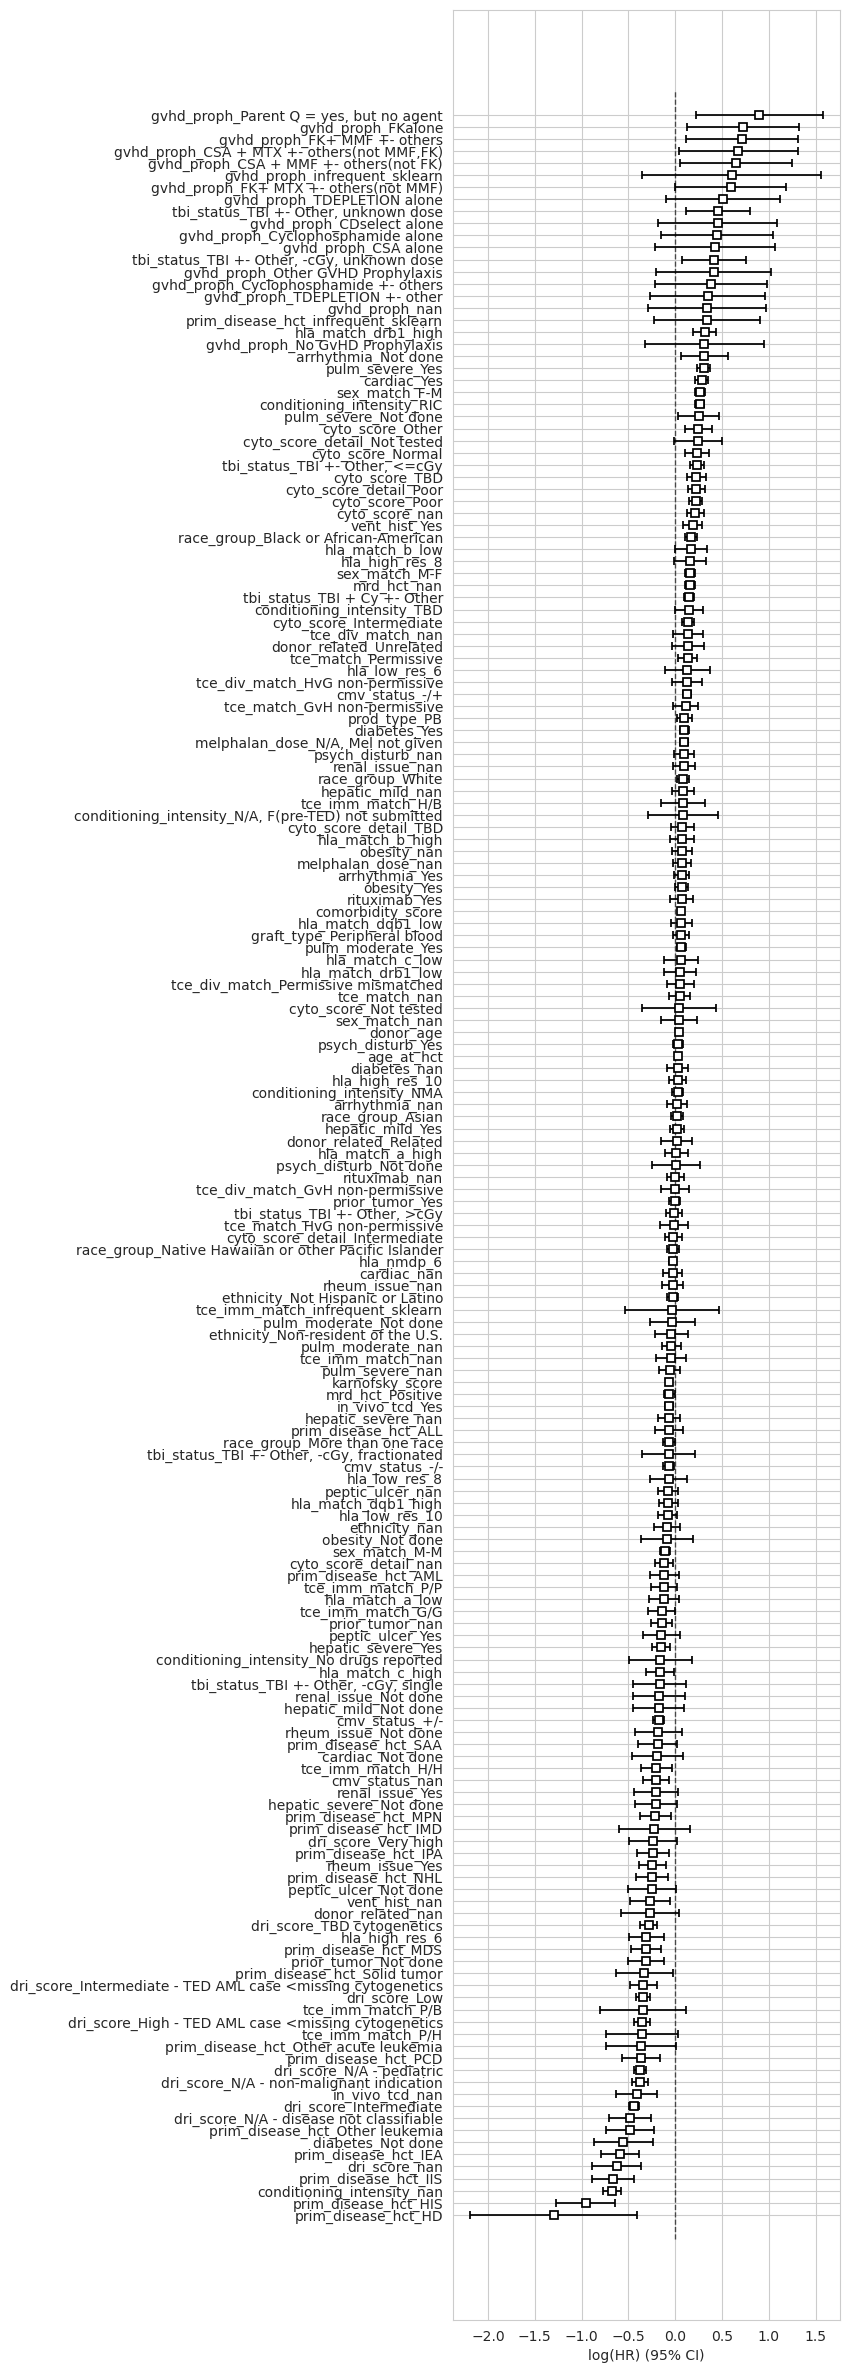

In [109]:
plt.figure(figsize=(5, 30))
cph.plot()
plt.show()

In [159]:
coefficient_info = pd.concat([cph.params_, cph.confidence_intervals_], axis=1).reset_index()
coefficient_info['abs_coef'] = abs(coefficient_info['coef'])
coefficient_info['zero not in conf int'] = coefficient_info['95% lower-bound'] * coefficient_info['95% upper-bound'] > 0
coefficient_info = coefficient_info.sort_values(by='covariate', ascending=False)

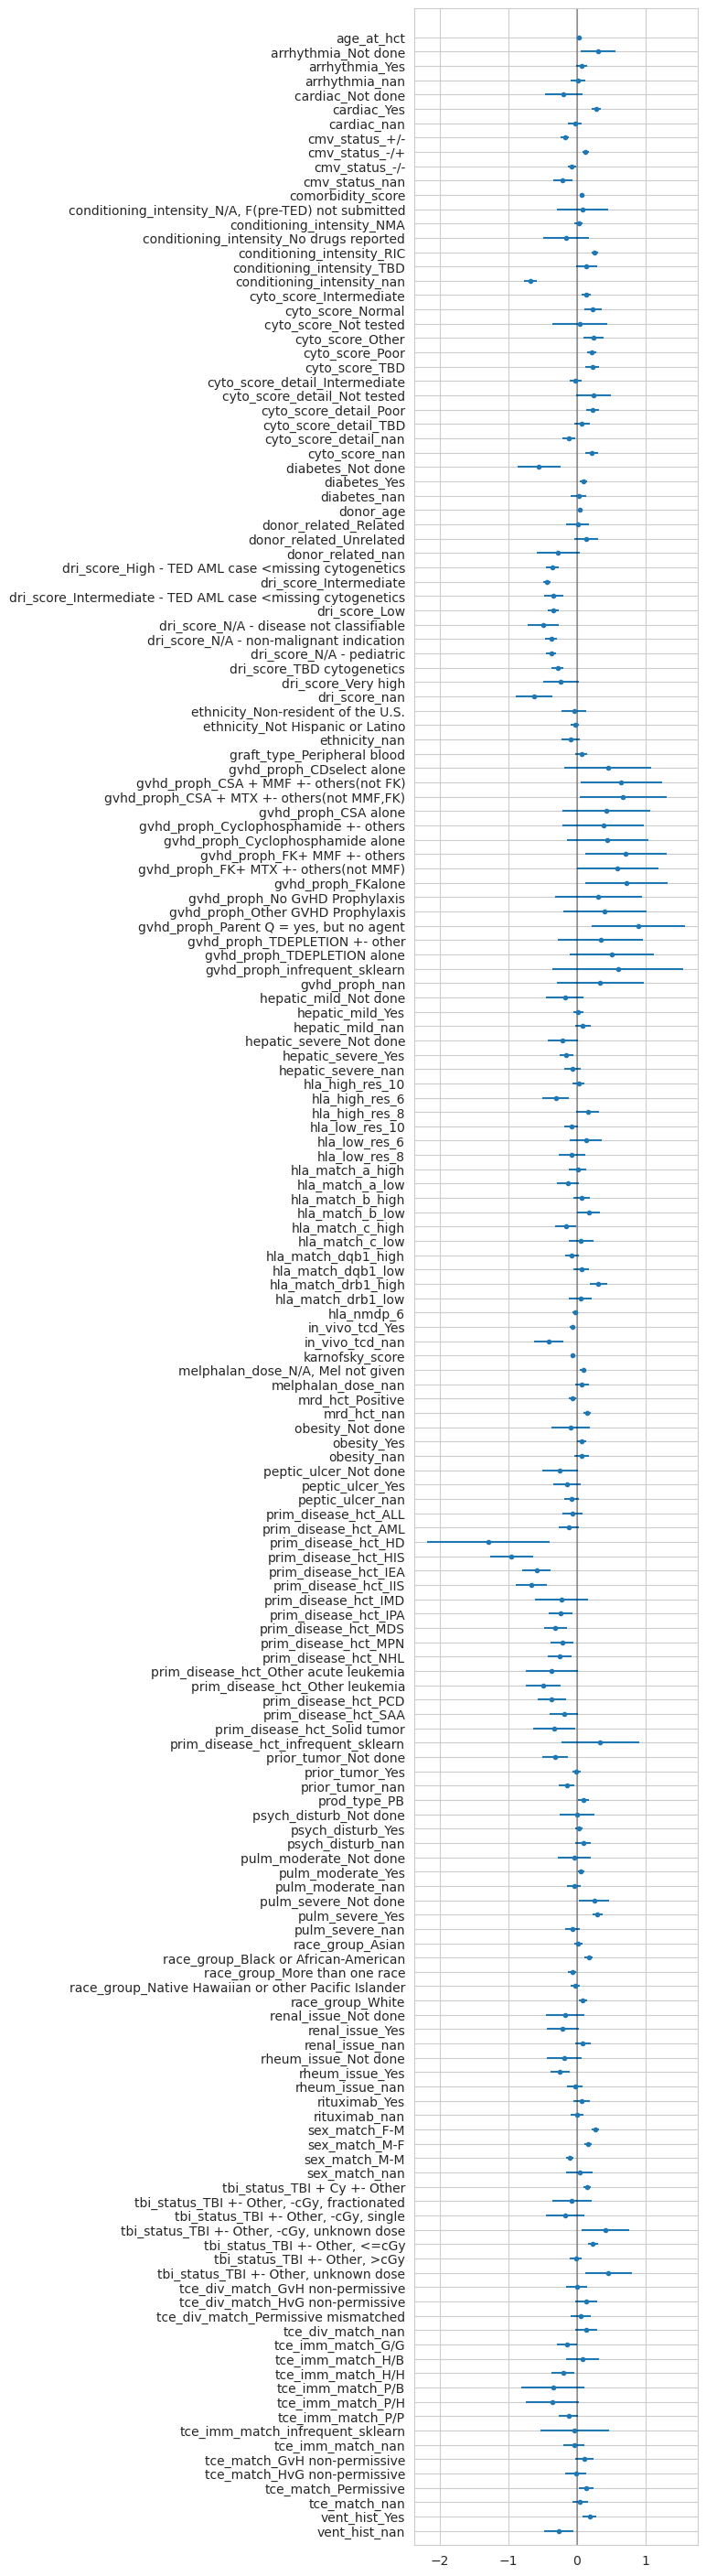

In [158]:
fig, ax = plt.subplots(figsize=(4, 36))
lower_error = (coefficient_info['coef'] - coefficient_info['95% lower-bound']).values,
upper_error = (coefficient_info['95% upper-bound'] - coefficient_info['coef']).values
errors = np.vstack((lower_error, upper_error))
ax.errorbar(coefficient_info['coef'], np.arange(175), xerr=errors, fmt='.')
plt.yticks(np.arange(175), coefficient_info['covariate'])
plt.ylim(-1, 176)
ax.axvline(x=0, color='black', alpha=0.3)
plt.show()

In [93]:
coefficient_info = coefficient_info.sort_values(by='covariate', ascending=True)
coefficient_info.head()

,covariate,coef,95% lower-bound,95% upper-bound,abs_coef,zero not in conf int
155,age_at_hct,0.033285,0.009059,0.057511,0.033285,True
30,arrhythmia_Not done,0.310600,0.058728,0.562473,0.310600,True
31,arrhythmia_Yes,0.070029,-0.010254,0.150313,0.070029,False
32,arrhythmia_nan,0.023812,-0.083151,0.130774,0.023812,False
148,cardiac_Not done,-0.190273,-0.465179,0.084633,0.190273,False


In [94]:
significant_coefs = coefficient_info.loc[coefficient_info['zero not in conf int']]
significant_coefs = significant_coefs.sort_values(by='coef', ascending=False)

In [95]:
significant_coefs.shape

(78, 6)

In [96]:
key_columns = significant_coefs.covariate.to_list() + ['efs', 'efs_time']
df_key = df_processed[key_columns]

In [97]:
# Fox a cox regression model out of the box
from lifelines import CoxPHFitter
cph2 = CoxPHFitter()
cph2.fit(df_key, duration_col='efs_time', event_col='efs')

<lifelines.CoxPHFitter: fitted with 23040 total observations, 10612 right-censored observations>

In [98]:
cph2.print_summary()

<lifelines.CoxPHFitter: fitted with 23040 total observations, 10612 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
      baseline estimation = breslow
   number of observations = 23040
number of events observed = 12428
   partial log-likelihood = -118201.67
         time fit was run = 2025-03-30 20:58:55 UTC

---
                                                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                    
gvhd_proph_Parent Q = yes, but no agent                      0.42      1.52      0.17            0.09            0.75                1.10                2.12
gvhd_proph_FKalone                                           0.24      1.28      0.05            0.14            0.35                1.15                1.41
gvhd_proph_FK+ MMF +- others                                 0.22      1.24      0.02            0.18            0.26                1.19                1.30
gvhd_proph_CSA + MTX +- others(not MMF,FK)                   0.16      1.17      0.12           -0.08            0.39                0.93                1.47
gvhd_proph_CSA + MMF +- others(not FK)                       0.16      1.17      0.04            0.08            0.24                1.08                1.27
tbi_status_TBI +- Other, unknown dose                        0.45      1.57      0.17            0.11            0.79                1.12                2.20
tbi_status_TBI +- Other, -cGy, unknown dose                  0.43      1.54      0.18            0.09            0.77                1.09                2.17
hla_match_drb1_high                                          0.32      1.38      0.04            0.23            0.41                1.26                1.50
arrhythmia_Not done                                          0.30      1.35      0.13            0.05            0.55                1.06                1.74
pulm_severe_Yes                                              0.31      1.36      0.04            0.24            0.38                1.27                1.46
cardiac_Yes                                                  0.29      1.34      0.04            0.22            0.36                1.25                1.43
sex_match_F-M                                                0.26      1.30      0.03            0.21            0.31                1.24                1.37
conditioning_intensity_RIC                                   0.25      1.28      0.02            0.20            0.29                1.23                1.34
pulm_severe_Not done                                         0.24      1.27      0.11            0.02            0.46                1.02                1.58
cyto_score_Other                                             0.25      1.29      0.07            0.11            0.40                1.12                1.49
cyto_score_Normal                                            0.24      1.28      0.06            0.12            0.37                1.12                1.45
tbi_status_TBI +- Other, <=cGy                               0.24      1.27      0.04            0.17            0.31                1.18                1.36
cyto_score_TBD                                               0.25      1.28      0.05            0.15            0.35                1.16                1.41
cyto_score_detail_Poor                                       0.20      1.22      0.03            0.14            0.26                1.15                1.30
cyto_score_Poor                                              0.22      1.25      0.03            0.16            0.29                1.17                1.33
cyto_score_nan                                               0.18      1.20      0.04            0.10            0.27                1.10                1

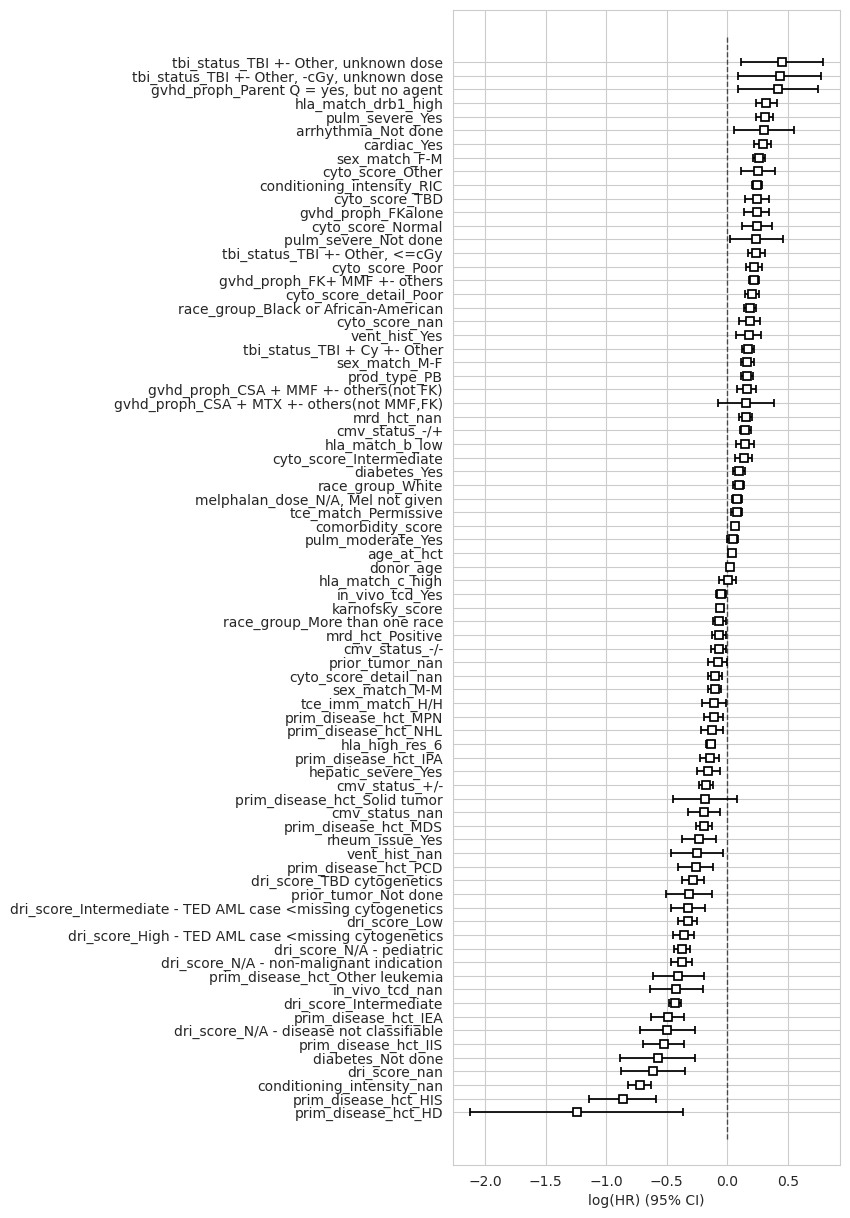

In [99]:
plt.figure(figsize=(5, 15))
cph2.plot()
plt.show()

In [100]:
for feat in df_processed.columns:
    if feat not in key_columns:
        print(feat)

dri_score_Very high
psych_disturb_Not done
psych_disturb_Yes
psych_disturb_nan
cyto_score_Not tested
diabetes_nan
tbi_status_TBI +- Other, -cGy, fractionated
tbi_status_TBI +- Other, -cGy, single
tbi_status_TBI +- Other, >cGy
arrhythmia_Yes
arrhythmia_nan
graft_type_Peripheral blood
renal_issue_Not done
renal_issue_Yes
renal_issue_nan
pulm_severe_nan
prim_disease_hct_ALL
prim_disease_hct_AML
prim_disease_hct_IMD
prim_disease_hct_Other acute leukemia
prim_disease_hct_SAA
prim_disease_hct_infrequent_sklearn
tce_imm_match_G/G
tce_imm_match_H/B
tce_imm_match_P/B
tce_imm_match_P/H
tce_imm_match_P/P
tce_imm_match_nan
tce_imm_match_infrequent_sklearn
rituximab_Yes
rituximab_nan
cyto_score_detail_Intermediate
cyto_score_detail_Not tested
cyto_score_detail_TBD
conditioning_intensity_N/A, F(pre-TED) not submitted
conditioning_intensity_NMA
conditioning_intensity_No drugs reported
conditioning_intensity_TBD
ethnicity_Non-resident of the U.S.
ethnicity_Not Hispanic or Latino
ethnicity_nan
obesity_